In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

The following sector is for necessary computation compenent needed

In [2]:
def sigmoid(x):
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        z = np.exp(x)
        return z / (1 + z)
    return 1.0 / (1.0 + np.exp(-x))
def sigmoid_gradient(y):
    return y*(1.0-y)

sigmoid = np.vectorize(sigmoid)
sigmoid_gradient = np.vectorize(sigmoid_gradient)

def binary_entropy(y_true,y_pred):
    return -1*(y_true*np.log(y_pred)+(1-y_true)*np.log(1-y_pred))


In [3]:
def accurcy(y_true,y_pred):
    """
    Mesures the accurcy of predictions with one-hot repretation
    """
    return np.array(np.argmax(y_pred,axis=1) == np.argmax(y_true,axis=1),dtype=np.float).mean()

Implementation with of MLP layer

In [4]:
class NN_layer(object):
    def __init__(self,input_size,hidden_size,reg=1e-4):
        self.reg = reg
        self.weights = np.random.randn(input_size,hidden_size).astype(np.float32)# * np.sqrt(2.0/input_size)
        self.bias = np.zeros(hidden_size).astype(np.float32)
    def forward(self,input_array):
        self.input = input_array
        self.ih = np.dot(input_array,self.weights)
        self.o = sigmoid(self.bias+self.ih)
        return self.o
    def backward(self,error_array,learning_rate):
        self.delta = sigmoid_gradient(self.o)*error_array
        self.delta = error_array
        self.g_bias = self.delta * self.bias / (self.ih+self.bias)
        self.g_ih = self.delta * self.ih / (self.ih+self.bias)
        self.g_input = np.dot(self.g_ih, self.weights.T)
        self.weights -= learning_rate * np.dot(self.input.T,self.g_ih)
        self.bias -= learning_rate * np.sum(self.g_bias,axis=0)
        return self.g_input

Implemenatation for MLP model

- implemenat forward and backward propagation using nn laery
- training and fitting function

In [5]:
class MLP():
    def __init__(self,input_size,hidden_unit, output_size,reg=1e-4):
        self.num_of_layer = len(hidden_unit)
        self.size = [input_size] + hidden_unit + [output_size]
        self.layers = [NN_layer(self.size[i],self.size[i+1],reg) for i in range(self.num_of_layer+1)]
        self.losses = []
        self.valid_acc = []
        self.reg = reg
    @property
    def parameters(self):
        return [layer.weights for layer in self.layers]
    @property
    def L2_reg(self):
        return sum([np.sum(np.power(parameter,2)) for parameter in self.parameters])
    def forward(self, X):
        feed = X
        for layer in self.layers:
            out = layer.forward(feed)
            feed = out
        return out
    def backward(self, error,learning_rate):
        error_bp = error
        for i in range(self.num_of_layer,-1,-1):
            error_bp = self.layers[i].backward(error_bp,learning_rate)
    def train(self, X, y,learning_rate):
        output = self.forward(X)
        loss = binary_entropy(y, output) # + self.reg*self.L2_reg
        self.backward(loss,learning_rate)
        return loss.mean()
    def fit(self, X, y, epoch, batch_size=1, learning_rate=0.1,shuffle=True,validation=False, valid_iter=None,valid_X=None,valid_y=None):
        data = list(zip(X,y))
        if shuffle:
            np.random.shuffle(data)
        batch_num = len(X)*epoch//batch_size+int((len(X)*epoch)%batch_size>0)
        data_gen = batch_gen(data,batch_size)
        for iteration in tqdm.tqdm(range(batch_num)):
            batch_X,batch_y = zip(*next(data_gen))
            loss = self.train(np.array(batch_X),np.array(batch_y),learning_rate)
            self.losses.append(loss)
            if validation and ((iteration+1)%valid_iter==0):
                valid_pred = self.forward(valid_X)
                acc = accurcy(valid_y, valid_pred)
                self.valid_acc.append(acc)

In [6]:
def to_categorical(y, num_classes=None):
    y = np.array(y, dtype=np.int)
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=np.float32)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [7]:
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [8]:
# Generator for giver batch size
def batch_gen(data,batch_size):
    full_len = len(data)
    start = 0
    while True:
        if start+batch_size<full_len:
            start+=batch_size
            yield data[start-batch_size:start]
        else:
            temp_start = start
            start = start+batch_size-full_len
            yield data[temp_start:]+data[:start]

In [9]:
iris = datasets.load_iris()
X = iris.data
y = to_categorical(iris.target)

print(X.shape[-1], y.shape[-1])

4 3


In [10]:
# devide the dataset into train valid and test
train_val_X,test_X,train_val_y, test_y = train_test_split(X,y,test_size=0.2)
train_X,val_X,train_y,val_y = train_test_split(train_val_X,train_val_y,test_size=0.2)

In [11]:
model = MLP(4,[8,8],3)

In [12]:
model.fit(train_X,train_y,epoch=10,batch_size=16,learning_rate=0.01,validation=True, valid_iter=10,valid_X=val_X,valid_y=val_y)

  0%|                                                                                           | 0/60 [00:00<?, ?it/s]c:\users\phili\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
c:\users\phili\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
c:\users\phili\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
c:\users\phili\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 599.98it/s]


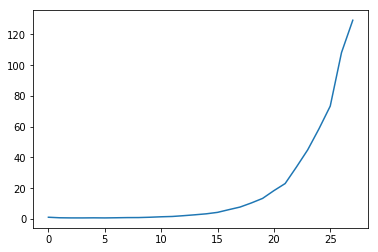

In [13]:
plt.plot(model.losses)

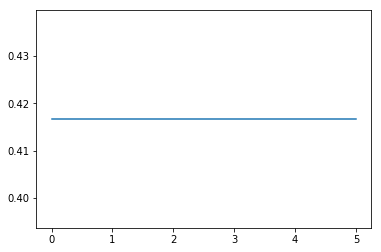

In [14]:
plt.plot(model.valid_acc)

## Review and explainatino
I didn't actually finish the assignment. Thought the main functional are completed. Instead of going down, the loss explode after several epoch and overflowed.
This may be caused by

1. Bad initalization: But after using xavier initialization it still performs the same.
2. Lack of regulation: L2 regulation doesn't imporve
3. Activation function I used sigmoid for activation and binary entropy for loss function. should try relu for activation and softmax (cross entropy) for loss